In [1]:
from google.colab import files
uploaded = files.upload()

Saving dataPreprocessed.csv to dataPreprocessed.csv


In [2]:
!pip install nltk

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
import nltk
nltk.download('stopwords')
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [4]:
import pandas as pd
import io
import spacy
from gensim.models.word2vec import Word2Vec
import re, string
from nltk.corpus import stopwords

stopword = stopwords.words('english')

df = pd.read_csv(io.StringIO(uploaded['dataPreprocessed.csv'].decode('utf-8')))
df


,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,...,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,label,annual_pay
0,1,Construction Superintendent,"Curtis Construction Company, Inc.","Stoughton, MA 02072",Onsite,"$60,000 - $130,000",Full-time,Greater Boston based General Contractor is see...,Construction Management,Civil Engineering,...,0.5,-0.062757,1,"$60,000 - $130,000",60000.0,130000.0,95000.0,95000.0,Medium,95000.0
1,2,Regional Construction Manager,Chipotle Mexican Grill,"Atlanta, GA 30309",Onsite,"$89,000 - $161,000",Contract,Regional Construction Manager\nDescription\n\n...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
2,3,Construction Project Manager,Perfetto Contracting Co Inc,"Brooklyn, NY",Onsite,"$170,000 - $200,000",Full-time,Innovating infrastructure one project at a tim...,Construction Management,Civil Engineering,...,2.5,-0.062757,1,"$170,000 - $200,000",170000.0,200000.0,185000.0,185000.0,High,185000.0
3,5,Construction Manager,Chipotle Mexican Grill,"Denver, CO 80210",Onsite,"$89,000 - $161,000",Contract,Construction Manager\nDescription\n\nCULTIVATI...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
4,7,Project Manager - Construction (Hawaii),Burns & McDonnell,"Honolulu, HI",Onsite,"$220,000 - $428,000",Full-time,Description\nThe Project Manager is responsibl...,Construction Management,Civil Engineering,...,0.7,-0.062757,1,"$220,000 - $428,000",220000.0,428000.0,324000.0,324000.0,High,324000.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5487,1206,TRAVEL AGENT,AppleOne,"San Juan, PR 00920",Onsite,$11 - $14,Contract,Plan and sell transportation and accommodation...,Travel Agent,Tourism,...,0.1,-0.062757,0,$11 - $14,11.0,14.0,12.5,26000.0,Low,26000.0
5488,1207,LOTTERY-Accounts Payable Travel Specialist (Ac...,Texas Comptroller of Public Accounts,"Austin, TX 78701",Onsite,"$2,748 - $3,750",Contract,LOTTERY-Accounts Payable Travel Specialist (Ac...,Travel Agent,Tourism,...,NaN,-0.062757,0,"$2,748 - $3,750",2748.0,3750.0,3249.0,3249.0,Low,3249.0
5489,1208,Reservation Specialist/Beach Services,Scupper's Watersports,"Saint Pete Beach, FL",Onsite,$13 - $15,Contract,Probably the best job on the island. We are a ...,Travel Agent,Tourism,...,0.1,-0.062757,0,$13 - $15,13.0,15.0,14.0,29120.0,Low,29120.0
5490,1213,Travel Coordinator,Renew Digital LLC,United States,Onsite,"$40,000 - $45,000",Full-time,TRAVEL COORDINATOR\nTHE OPPORTUNITY:\nBecause ...,Travel Agent,Tourism,...,0.1,-0.062757,1,"$40,000 - $45,000",40000.0,45000.0,42500.0,42500.0,Low,42500.0


In [5]:
class_df = df.groupby('label').count()
class_df.style.background_gradient(cmap='PiYG')

,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,experience,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,annual_pay
label,,,,,,,,,,,,,,,,,,,,
High,1478,1478,1478,1478,1478,1478,1478,1478,1478,1478,946,946,1478,1478,1478,1478,1478,1478,1478,1478
Low,1652,1652,1652,1652,1652,1652,1652,1652,1652,1652,802,802,1652,1652,1652,1652,1652,1652,1652,1652
Medium,2362,2362,2348,2362,2362,2362,2362,2362,2361,2361,1528,1528,2362,2362,2362,2362,2362,2362,2362,2362


In [6]:
def clean(text):
    text = text.lower() # lower case
    text = re.sub(r'https?://\S+|www\.\S+', " ", text)#URL
    text = re.sub(r'@\w+',' ',text) # mentions
    text = re.sub(r'#\w+', ' ', text) #hashtags
    text= re.sub(r'[^\w\s]',' ',text) #punctuations
    text= re.sub(r'\d+', ' ', text) #digits
    text = re.sub('\[.*?\]',' ', text) #any punctuations left
    text = re.sub("[^a-z0-9]"," ", text)# any others charcters other than numbers and letters
    text = text.split() #stopwords
    text = " ".join([word for word in text if not word in stopword])
    return text

df['Job_Description'] = df['Job_Description'].astype(str).apply(lambda x: clean(x))

In [7]:
df.head(10)

,X,Title,Company,Location,Type,Salary,Contract_type,Job_Description,JobType,Industry,...,exp_normailzed,type_norm,Contract_type_norm,salary1,salary_min,salary_max,salary_avg,salary_norm,label,annual_pay
0,1,Construction Superintendent,"Curtis Construction Company, Inc.","Stoughton, MA 02072",Onsite,"$60,000 - $130,000",Full-time,greater boston based general contractor seekin...,Construction Management,Civil Engineering,...,0.5,-0.062757,1,"$60,000 - $130,000",60000.0,130000.0,95000.0,95000.0,Medium,95000.0
1,2,Regional Construction Manager,Chipotle Mexican Grill,"Atlanta, GA 30309",Onsite,"$89,000 - $161,000",Contract,regional construction manager description cult...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
2,3,Construction Project Manager,Perfetto Contracting Co Inc,"Brooklyn, NY",Onsite,"$170,000 - $200,000",Full-time,innovating infrastructure one project time per...,Construction Management,Civil Engineering,...,2.5,-0.062757,1,"$170,000 - $200,000",170000.0,200000.0,185000.0,185000.0,High,185000.0
3,5,Construction Manager,Chipotle Mexican Grill,"Denver, CO 80210",Onsite,"$89,000 - $161,000",Contract,construction manager description cultivating b...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$89,000 - $161,000",89000.0,161000.0,125000.0,125000.0,High,125000.0
4,7,Project Manager - Construction (Hawaii),Burns & McDonnell,"Honolulu, HI",Onsite,"$220,000 - $428,000",Full-time,description project manager responsible managi...,Construction Management,Civil Engineering,...,0.7,-0.062757,1,"$220,000 - $428,000",220000.0,428000.0,324000.0,324000.0,High,324000.0
5,8,Construction Manager,Black & Veatch Corporation,"San Diego, CA",Onsite,"$178,000 - $220,000",Full-time,together company future shared success employe...,Construction Management,Civil Engineering,...,10.0,-0.062757,1,"$178,000 - $220,000",178000.0,220000.0,199000.0,199000.0,High,199000.0
6,12,Construction Sales - Project Management,The Neill Company,"Orange Park, FL 32073",Onsite,"$65,000 - $135,000",Contract,neill company premier commercial residential c...,Construction Management,Civil Engineering,...,1.5,-0.062757,0,"$65,000 - $135,000",65000.0,135000.0,100000.0,100000.0,Medium,100000.0
7,16,Residential Construction Project Manager,RTG,"San Jose, CA",Onsite,"$125,000 - $150,000",Full-time,well established growing construction company ...,Construction Management,Civil Engineering,...,NaN,-0.062757,1,"$125,000 - $150,000",125000.0,150000.0,137500.0,137500.0,High,137500.0
8,18,Experienced Construction Management Specialist,BOEING,"Springfield, VA",Onsite,"$93,500 - $126,500",Contract,boeing innovate collaborate make world better ...,Construction Management,Civil Engineering,...,0.1,-0.062757,0,"$93,500 - $126,500",93500.0,126500.0,110000.0,110000.0,Medium,110000.0
9,19,"Residential Property/Construction Manager, Gen...",Soar Real Estate,"Fort Lee, NJ",Onsite,"$140,000 - $190,000",Full-time,residential property manager general manager c...,Construction Management,Civil Engineering,...,0.3,-0.062757,1,"$140,000 - $190,000",140000.0,190000.0,165000.0,165000.0,High,165000.0


In [8]:
import spacy

# spacy.load is a method in the Spacy library for loading pre-trained models for natural language processing.
# load english language model and create nlp object from it
# Pre-trained English language model called en_core_web_sm. 
# This model is a small and fast model for English language text processing, and it includes features such as part-of-speech tagging, named entity recognition, and dependency parsing
nlp = spacy.load("en_core_web_sm") 

def preprocess(text):
    #For converting paragrapg to sentence
    # spacy. is object oriented
    # Dr. Ram is eating.He is not available.
    # -> [Dr. Ram is eating. He is not available]
    doc = nlp(text)

    filtered_tokens = []
    for token in doc:
        if token.is_stop or token.is_punct:
            continue
        filtered_tokens.append(token.lemma_)
    
    return " ".join(filtered_tokens) 

In [9]:
df['preprocessed_txt'] = df['Job_Description'].apply(preprocess) 

In [10]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(
    df.preprocessed_txt, 
    df.label, 
    test_size=0.2, # 20% samples will go to test dataset
    random_state=2022, #keep using the same sample for training or testing
    stratify=df.label #balance category used in training the model
)

### ***N-gram (n=5)*** 

In [12]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

# create CountVectorizer object
vectorizer = CountVectorizer(ngram_range= (1,5)).fit(x_train)
train_X_cv = vectorizer.fit_transform(x_train)
test_X_cv = vectorizer.transform(x_test)

tfidf_transformer = TfidfTransformer()
train_X_tfidf = tfidf_transformer.fit_transform(train_X_cv)
test_X_tfidf = tfidf_transformer.transform(test_X_cv)

### ***Logistic Regression N-gram (n=5) C=1*** 

1.   List item
2.   List item






              precision    recall  f1-score   support

        High       0.90      0.70      0.79       296
         Low       0.88      0.83      0.85       330
      Medium       0.77      0.91      0.84       473

    accuracy                           0.83      1099
   macro avg       0.85      0.81      0.83      1099
weighted avg       0.84      0.83      0.83      1099



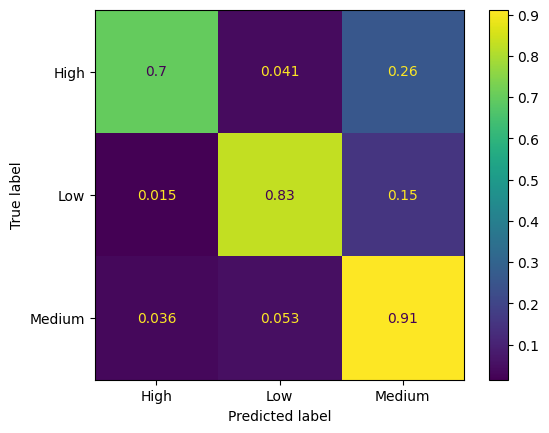

In [14]:

lr = LogisticRegression(penalty="l2",multi_class = "multinomial",solver = "saga", C=1, max_iter=5000)
lr.fit(train_X_tfidf,y_train)
lr_pred = lr.predict(test_X_tfidf)
print(classification_report(y_test, lr_pred))
lr_cm = confusion_matrix(y_test, lr_pred, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr.classes_)
disp.plot()
plt.show()

### ***Logistic Regression N-gram (n=5) C=10*** 


              precision    recall  f1-score   support

        High       0.90      0.79      0.84       296
         Low       0.88      0.87      0.88       330
      Medium       0.82      0.89      0.85       473

    accuracy                           0.86      1099
   macro avg       0.87      0.85      0.86      1099
weighted avg       0.86      0.86      0.86      1099



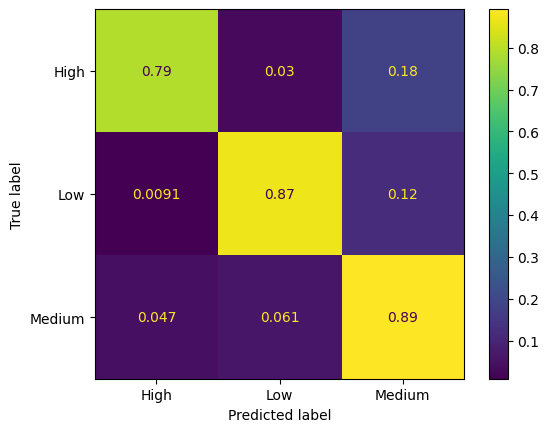

In [21]:
lr = LogisticRegression(penalty="l2",multi_class = "multinomial",solver = "saga", C=10, max_iter=5000)
lr.fit(train_X_tfidf,y_train)
lr_pred = lr.predict(test_X_tfidf)
print(classification_report(y_test, lr_pred))
lr_cm = confusion_matrix(y_test, lr_pred, normalize="true")

disp = ConfusionMatrixDisplay(confusion_matrix=lr_cm, display_labels=lr.classes_)
disp.plot()
plt.show()

### ***Multinomial Naive Bayes N-gram (n=5) aplha=0.1*** 


              precision    recall  f1-score   support

        High       0.90      0.65      0.76       296
         Low       0.90      0.77      0.83       330
      Medium       0.73      0.92      0.81       473

    accuracy                           0.81      1099
   macro avg       0.84      0.78      0.80      1099
weighted avg       0.83      0.81      0.80      1099



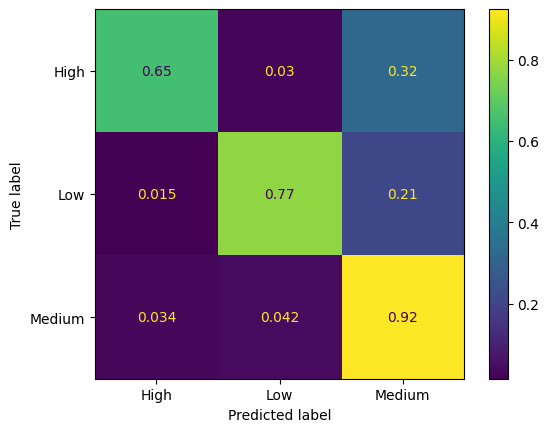

In [15]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

nb = MultinomialNB(alpha=0.1, fit_prior=True)
nb.fit(train_X_tfidf,y_train)
nb_pred = nb.predict(test_X_tfidf)
print(classification_report(y_test, nb_pred))

nb_cm = confusion_matrix(y_test, nb_pred, normalize="true")

display = ConfusionMatrixDisplay(confusion_matrix=nb_cm, display_labels=nb.classes_)
display.plot()
plt.show()

### Tri-grams


In [17]:
# create CountVectorizer object
vectorizer_3 = CountVectorizer(ngram_range= (1,3)).fit(x_train)

# fit_transform on training data
train_X_cv_3 = vectorizer.fit_transform(x_train)
# transform test data
test_X_cv_3 = vectorizer.transform(x_test)

# create TfidfTransformer object
tfidf_transformer = TfidfTransformer()

train_X_tfidf_3 = tfidf_transformer.fit_transform(train_X_cv_3)
test_X_tfidf_3 = tfidf_transformer.transform(test_X_cv_3)

### **Multinomial Naive Bayes Tri-gram (n=3) alpha=1**




              precision    recall  f1-score   support

        High       0.95      0.31      0.46       296
         Low       0.92      0.53      0.67       330
      Medium       0.57      0.97      0.72       473

    accuracy                           0.66      1099
   macro avg       0.81      0.60      0.62      1099
weighted avg       0.77      0.66      0.63      1099



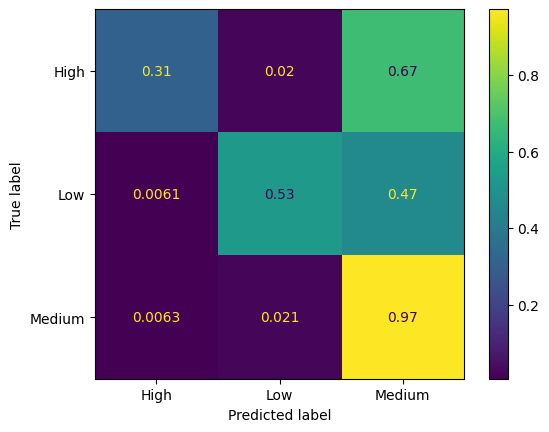

In [18]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#Without alpha
nb_3 = MultinomialNB()
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
print(classification_report(y_test, nb_pred_3))

nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

### **Multinomial Naive Bayes Tri-gram (n=3) alpha=0.1**


              precision    recall  f1-score   support

        High       0.90      0.65      0.76       296
         Low       0.90      0.77      0.83       330
      Medium       0.73      0.92      0.81       473

    accuracy                           0.81      1099
   macro avg       0.84      0.78      0.80      1099
weighted avg       0.83      0.81      0.80      1099



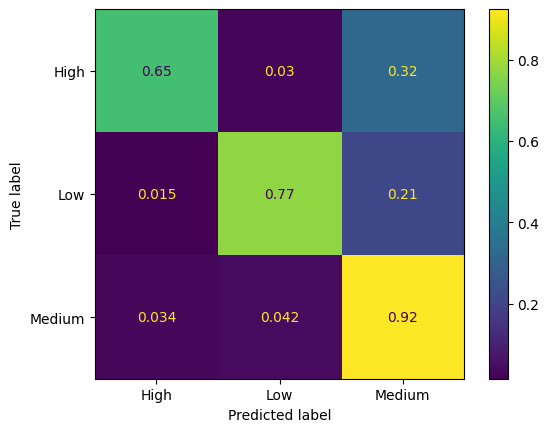

In [19]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline

#With alpha
nb_3 = MultinomialNB(alpha=0.1, fit_prior=True)
nb_3.fit(train_X_tfidf_3,y_train)
nb_pred_3 = nb_3.predict(test_X_tfidf_3)
print(classification_report(y_test, nb_pred_3))
nb_cm_3 = confusion_matrix(y_test, nb_pred_3, normalize="true")

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()

### **LogisticRegression Tri-gram (n=3) C=10**


              precision    recall  f1-score   support

        High       0.90      0.79      0.84       296
         Low       0.89      0.87      0.88       330
      Medium       0.82      0.89      0.85       473

    accuracy                           0.86      1099
   macro avg       0.87      0.85      0.86      1099
weighted avg       0.86      0.86      0.86      1099



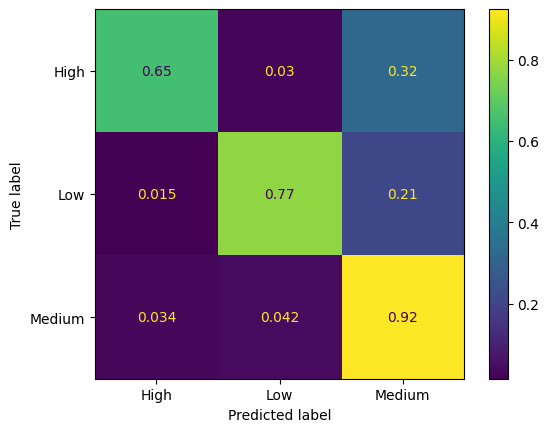

In [20]:
lr_3 = LogisticRegression(penalty="l2",multi_class = "multinomial",solver = "saga", C=10, max_iter=5000)
lr_3.fit(train_X_tfidf_3,y_train)
lr_pred_3 = lr_3.predict(test_X_tfidf_3)
print(classification_report(y_test, lr_pred_3))

display_3 = ConfusionMatrixDisplay(confusion_matrix=nb_cm_3, display_labels=nb_3.classes_)
display_3.plot()
plt.show()